In [5]:
import itertools
import librosa
import scipy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import librosa.display
from data.IEMOCAP import IEMOCAP
from data.COMMANDS import COMMANDS
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch.autograd import Variable

def _bn_function_factory(conv, norm, prelu):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = norm(prelu(conv(concated_features)))
        return bottleneck_output

    return bn_function

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate):
        super(_DenseLayer, self).__init__()
        
        self.conv0 = nn.Conv1d(num_input_features, 4 * growth_rate, kernel_size=3, padding=1, bias=True)
        self.norm0 = nn.BatchNorm1d(4 * growth_rate)

        self.PReLU = nn.PReLU(num_parameters=1, init=0.05)
        
        self.conv1 = nn.Conv1d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=True)
        self.norm1 = nn.BatchNorm1d(growth_rate)

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.conv0, self.norm0, self.PReLU)
        if any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.norm1(self.conv1(bottleneck_output))
        return new_features
    
class _DenseBlock(nn.Module):
    def __init__(self, nChannels, growth_rate):
        super(_DenseBlock, self).__init__()
        layer = _DenseLayer(nChannels, growth_rate)
        self.add_module('denselayer', layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class EdgeRNN(nn.Module):
    def __init__(self, num_class):
        super(EdgeRNN, self).__init__()

        self.output_size = num_class
        num_features = 152
        growth_rate = 16
        
        self.dense1 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense2 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense3 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense4 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense5 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense6 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense7 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense8 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense9 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense10 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense11 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense12 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        
        self.MaxPool1d = nn.MaxPool1d(2,2)
        
        self.RNN = nn.RNN(num_features, num_features, 1, batch_first=True,
                              dropout=0,bidirectional=False)
        self.Tanh = nn.Tanh()
        self.out = nn.Linear(num_features, self.output_size)

    
    def forward(self, x):
        
        x = x.float()
        
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense6(x)
        x = self.dense7(x)
        x = self.dense8(x)
        x = self.dense9(x)
        x = self.dense10(x)
        x = self.dense11(x)
        x = self.dense12(x)
        
        x = self.MaxPool1d(x)
        
        x = x.permute(0, 2, 1)
        x, h_n = self.RNN(x)
        
        residual = x 
        x = F.sigmoid(x)
        residual = residual * x
        residual = (residual.sum(1)) / (x.sum(1))
        residual = self.Tanh(residual)

        x = self.out(residual)
        
        return x

In [6]:
def confusion_matrix(preds, y, NUM_CLASSES):
    """ Returns confusion matrix """
    assert preds.shape[0] == y.shape[0], "1 dim of predictions and labels must be equal"
    rounded_preds = torch.argmax(preds,1)
    conf_mat = np.zeros((NUM_CLASSES, NUM_CLASSES))
    for i in range(rounded_preds.shape[0]):
        predicted_class = rounded_preds[i]
        correct_class = y[i]
        conf_mat[correct_class][predicted_class] += 1
    return conf_mat

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

This is IEMOCAP
[[178.  27.  27.  96.]
 [ 25. 164.   5.  27.]
 [ 36.   7. 130.  44.]
 [ 49.  25.  31. 237.]]
Confusion matrix, without normalization
[[178  27  27  96]
 [ 25 164   5  27]
 [ 36   7 130  44]
 [ 49  25  31 237]]


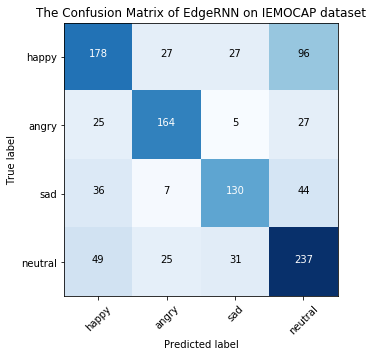

In [7]:
print ("This is IEMOCAP")
NUM_CLASSES = 4
PrivateTestset = IEMOCAP(split = 'PrivateTest')
PrivateTestloader = torch.utils.data.DataLoader(PrivateTestset, batch_size=64, shuffle=False, num_workers=1)

net = EdgeRNN(num_class=NUM_CLASSES) 
Private_checkpoint = torch.load('EdgeRNN_IEMOCAP_model.pt')
net.load_state_dict(Private_checkpoint['net'], strict=False)

net.cuda()
net.eval()
conf_mat = np.zeros((NUM_CLASSES, NUM_CLASSES))
for batch_idx, (inputs, targets) in enumerate(PrivateTestloader):
    
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)

    conf_mat += confusion_matrix(outputs, targets, NUM_CLASSES)
print (conf_mat)
attack_types = ['happy', 'angry', 'sad', 'neutral']
plt.figure(figsize=(5, 5))
plot_confusion_matrix(conf_mat.astype(int), classes=attack_types, normalize=False, title='The Confusion Matrix of EdgeRNN on IEMOCAP dataset')
plt.show()
plt.close()

This is COMMANDS
[[8.134e+03 6.000e+00 1.300e+01 9.000e+00 7.000e+00 9.000e+00 9.000e+00
  7.000e+00 5.000e+00 9.000e+00 1.100e+01]
 [1.500e+01 4.600e+02 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.800e+01 1.000e+00 4.510e+02 0.000e+00 3.000e+00 3.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 5.000e+00]
 [1.700e+01 0.000e+00 0.000e+00 4.460e+02 0.000e+00 1.000e+00 0.000e+00
  2.000e+00 6.000e+00 2.000e+00 1.000e+00]
 [2.800e+01 0.000e+00 7.000e+00 0.000e+00 4.350e+02 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 2.000e+00]
 [2.000e+01 4.000e+00 1.000e+00 0.000e+00 0.000e+00 4.450e+02 0.000e+00
  1.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [3.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 4.430e+02
  0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [4.300e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  4.170e+02 6.000e+00 0.000e+00 0.000e+00]
 [1.800e+01 1.000e+00 1.000e+00 1.500e+01 0.000e+00 0.000e+00 0

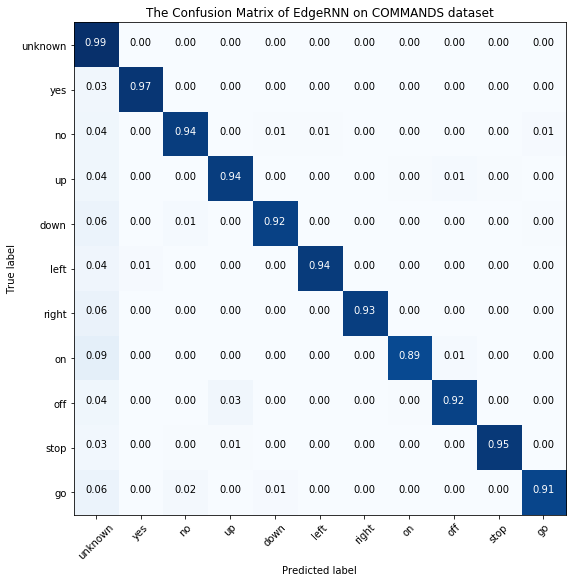

In [8]:
print ("This is COMMANDS")
NUM_CLASSES = 11
PrivateTestset = COMMANDS(split = 'PrivateTest')
PrivateTestloader = torch.utils.data.DataLoader(PrivateTestset, batch_size=64, shuffle=False, num_workers=1)

net = EdgeRNN(num_class=NUM_CLASSES) 
Private_checkpoint = torch.load('EdgeRNN_COMMANDS_model.pt')
net.load_state_dict(Private_checkpoint['net'], strict=False)

net.cuda()
net.eval()
conf_mat = np.zeros((NUM_CLASSES, NUM_CLASSES))
for batch_idx, (inputs, targets) in enumerate(PrivateTestloader):
    
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)

    conf_mat += confusion_matrix(outputs, targets, NUM_CLASSES)
print (conf_mat)
attack_types = ['unknown', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat, classes=attack_types, normalize=True, title='The Confusion Matrix of EdgeRNN on COMMANDS dataset')
plt.show()
plt.close()